In [11]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import sys
import os

# Add project root to path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

from src.model import get_model
from src.data_loader import get_dataloaders

In [ ]:
# Dataset paths
DATA_DIR = "/Users/erenaskin/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2/chest_xray"
COVID_DIR = "/Users/erenaskin/.cache/kagglehub/datasets/tawsifurrahman/covid19-radiography-database/versions/5"
PRASHANT_DIR = "/Users/erenaskin/.cache/kagglehub/datasets/prashant268/chest-xray-covid19-pneumonia/versions/2/Data"
NIH_DIR = "/Users/erenaskin/.cache/kagglehub/datasets/nih-chest-xrays/sample/versions/4"
BACHRR_DIR = "/Users/erenaskin/.cache/kagglehub/datasets/bachrr/covid-chest-xray/versions/4"

# Model Path and Settings
MODEL_PATH = "../models/pneumonia_covid_resnet50.pth"
DEVICE = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")
class_names = ['NORMAL', 'PNEUMONIA', 'COVID-19']

print(f"Pneumonia Dataset: {DATA_DIR}")
print(f"COVID Dataset: {COVID_DIR}")
print(f"Prashant Dataset: {PRASHANT_DIR}")
print(f"NIH Dataset: {NIH_DIR}")
print(f"Bachrr Dataset: {BACHRR_DIR}")
print(f"Model Path: {MODEL_PATH}")
print(f"Device: {DEVICE}")
print(f"Classes: {class_names}")

Pneumonia Dataset: /Users/erenaskin/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2/chest_xray
COVID Dataset: /Users/erenaskin/.cache/kagglehub/datasets/tawsifurrahman/covid19-radiography-database/versions/5
Prashant Dataset: /Users/erenaskin/.cache/kagglehub/datasets/prashant268/chest-xray-covid19-pneumonia/versions/2/Data
NIH Dataset: /Users/erenaskin/.cache/kagglehub/datasets/nih-chest-xrays/sample/versions/4
Bachrr Dataset: /Users/erenaskin/.cache/kagglehub/datasets/bachrr/covid-chest-xray/versions/4
Model Path: ../models/pneumonia_covid_resnet50.pth
Device: mps
Classes: ['NORMAL', 'PNEUMONIA', 'COVID-19']


In [ ]:
# Create data loaders
dataloaders, datasets = get_dataloaders(
    DATA_DIR, 
    COVID_DIR, 
    PRASHANT_DIR, 
    nih_dir=NIH_DIR, 
    bachrr_dir=BACHRR_DIR,
    batch_size=32
)

train_loader = dataloaders['train']
val_loader = dataloaders['val']
test_loader = dataloaders['test']

print(f"Train batches: {len(train_loader)}")
print(f"Val batches: {len(val_loader)}")
print(f"Test batches: {len(test_loader)}")

Train batches: 788
Val batches: 99
Test batches: 118


In [14]:
# Load Model
print("Loading model...")
model = get_model(num_classes=3, feature_extract=False)
if os.path.exists(MODEL_PATH):
    model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
    model.to(DEVICE)
    model.eval()
    print("Model loaded successfully.")
else:
    print(f"Error: Model file not found at {MODEL_PATH}")

Loading model...
Model loaded successfully.
Model loaded successfully.


In [15]:
# Run Predictions
all_preds = []
all_labels = []

print("Running predictions on validation set...")
with torch.no_grad():
    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

print("Predictions complete.")

Running predictions on validation set...
Predictions complete.
Predictions complete.


## 1. Confusion Matrix

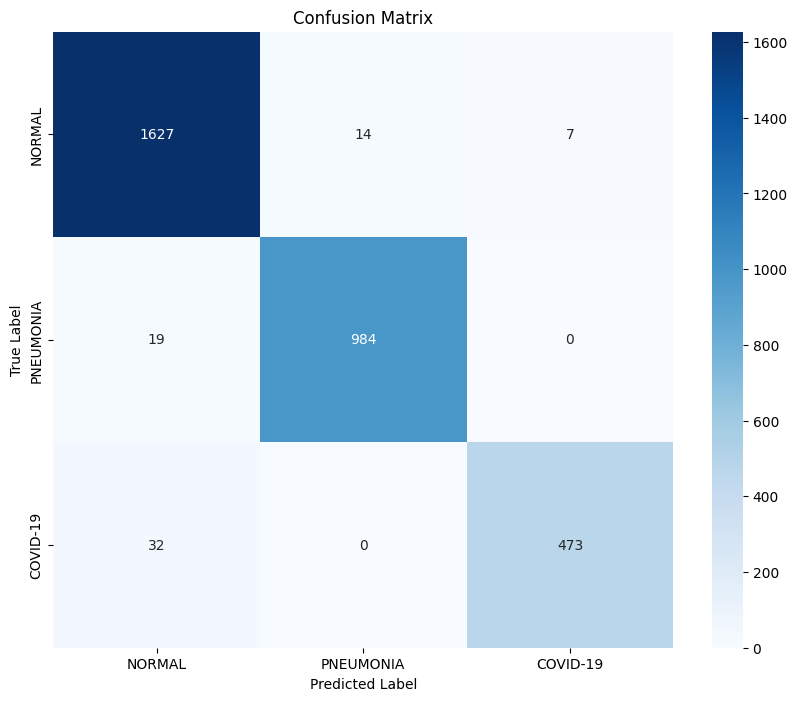

In [16]:
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

## 2. Classification Report

In [17]:
print(classification_report(all_labels, all_preds, target_names=class_names))

              precision    recall  f1-score   support

      NORMAL       0.97      0.99      0.98      1648
   PNEUMONIA       0.99      0.98      0.98      1003
    COVID-19       0.99      0.94      0.96       505

    accuracy                           0.98      3156
   macro avg       0.98      0.97      0.97      3156
weighted avg       0.98      0.98      0.98      3156



## 3. Sample Predictions Visualization
Green title indicates correct prediction, Red indicates incorrect.

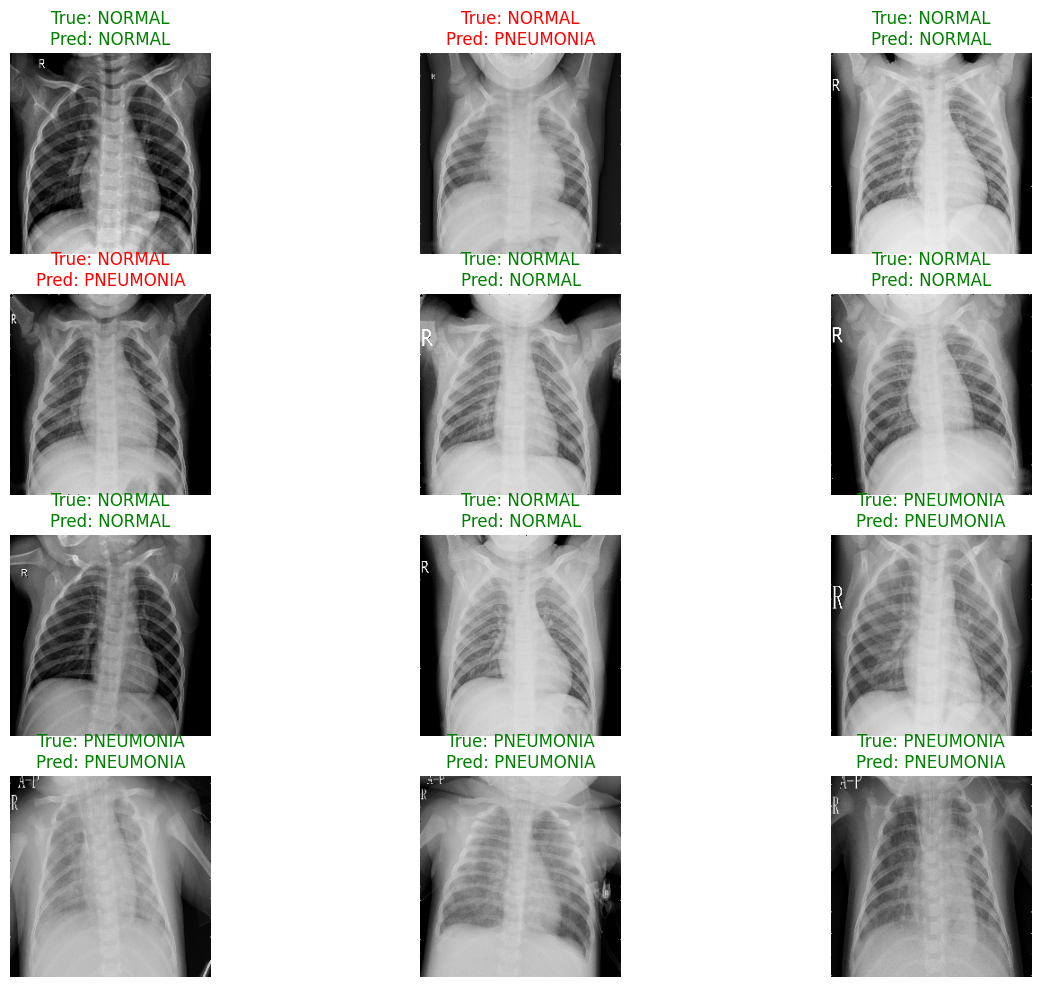

In [18]:
def visualize_model(model, num_images=12):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure(figsize=(15, 12))

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(val_loader):
            inputs = inputs.to(DEVICE)
            labels = labels.to(DEVICE)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(4, 3, images_so_far)
                ax.axis('off')
                
                # Un-normalize for display
                img = inputs.cpu().data[j].numpy().transpose((1, 2, 0))
                mean = np.array([0.485, 0.456, 0.406])
                std = np.array([0.229, 0.224, 0.225])
                img = std * img + mean
                img = np.clip(img, 0, 1)
                
                ax.imshow(img)
                color = 'green' if preds[j] == labels[j] else 'red'
                ax.set_title(f'True: {class_names[labels[j]]}\nPred: {class_names[preds[j]]}', color=color)

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

visualize_model(model, num_images=12)